In [40]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import joblib
import tensorflow as tf

In [41]:
# Configuración de la semilla para reproducibilidad
np.random.seed(42)

# Número de muestras
n_samples = 500

# Generación de características sintéticas
# Por ejemplo, tamaño de la casa (en pies cuadrados), número de habitaciones, etc.
house_size = np.random.normal(1500, 300, n_samples)
num_rooms = np.random.randint(2, 8, n_samples)
age = np.random.randint(0, 100, n_samples)
distance_to_city_center = np.random.normal(10, 5, n_samples)
population_density = np.random.normal(3000, 1000, n_samples)

# Precio de la vivienda (target) generado sintéticamente
# La fórmula es arbitraria y solo para fines de ejemplo
price = (house_size * 200) + (num_rooms * 5000) - (age * 100) - (distance_to_city_center * 300) + (population_density * 2) + np.random.normal(0, 10000, n_samples)

# Creación del DataFrame
data = {
    'house_size': house_size,
    'num_rooms': num_rooms,
    'age': age,
    'distance_to_city_center': distance_to_city_center,
    'population_density': population_density,
    'price': price
}

df = pd.DataFrame(data)
df.tail(10)

,house_size,num_rooms,age,distance_to_city_center,population_density,price
490,1497.608208,3,32,11.694326,3426.495819,317509.579918
491,1943.983242,3,76,14.084359,2660.954697,399471.568852
492,1523.210492,6,25,15.499525,1407.398916,325208.453486
493,1241.614740,2,21,5.709472,2242.450289,238254.247217
494,1956.937223,2,65,12.165603,2530.726595,394171.134410
495,1661.673013,2,37,15.935221,2302.266217,338084.830289
496,1188.826154,2,89,5.064591,3059.552968,239792.669429
497,1442.898397,2,45,17.433736,2658.112264,275804.038495
498,1237.314524,6,14,18.194704,3172.121372,292896.076374
499,1085.160081,4,97,23.125432,4202.627301,222411.025955


In [42]:
df2 = df.copy()
print('Número de observaciones (filas) = {}'.format(df2.shape[0]))
print('Total de variables disponibles (columnas) = {} '.format(df2.columns.shape[0]))
print('Columnas que cuentan con un valor nulo -')
print(df2.isnull().sum())

Número de observaciones (filas) = 500
Total de variables disponibles (columnas) = 6 
Columnas que cuentan con un valor nulo -
house_size                 0
num_rooms                  0
age                        0
distance_to_city_center    0
population_density         0
price                      0
dtype: int64


In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   house_size               500 non-null    float64
 1   num_rooms                500 non-null    int32  
 2   age                      500 non-null    int32  
 3   distance_to_city_center  500 non-null    float64
 4   population_density       500 non-null    float64
 5   price                    500 non-null    float64
dtypes: float64(4), int32(2)
memory usage: 19.7 KB


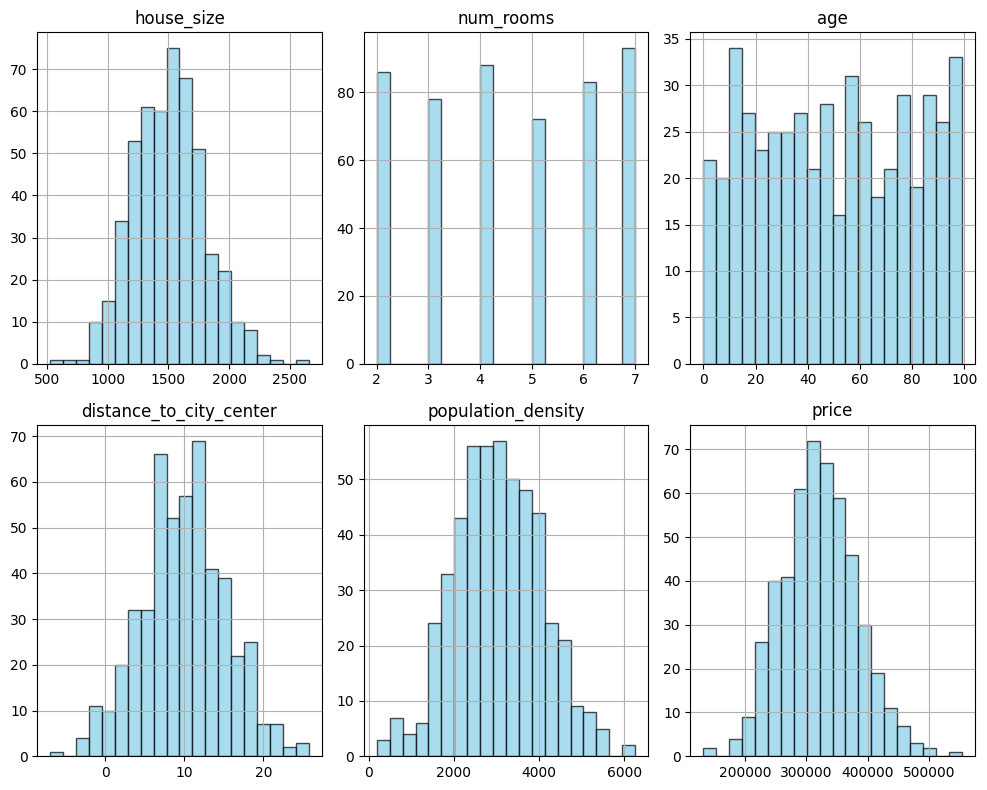

In [45]:
# Crear histogramas mejorados

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
df2.hist(ax=axes, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Columnas
axes[0,0].set_title('house_size')
axes[0,1].set_title('num_rooms')
axes[0,2].set_title('age')
axes[1,0].set_title('distance_to_city_center')
axes[1,1].set_title('population_density')
axes[1,2].set_title('price')

# Titutlos
plt.tight_layout()
plt.show()


In [46]:
# Definir características numéricas y categóricas
numeric_features = ['house_size','num_rooms','age','distance_to_city_center','population_density','price']

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2[numeric_features] = scaler.fit_transform(df2[numeric_features])

In [48]:
df2.tail(10)

,house_size,num_rooms,age,distance_to_city_center,population_density,price
490,-0.015109,-0.879687,-0.619484,0.318665,0.369862,-0.070612
491,1.502753,-0.879687,0.879652,0.765792,-0.374829,1.269053
492,0.071950,0.840692,-0.857983,1.030541,-1.594243,0.055225
493,-0.885594,-1.453147,-0.994268,-0.800979,-0.781935,-1.366038
494,1.546802,-1.453147,0.504868,0.406832,-0.501510,1.182418
495,0.542780,-1.453147,-0.449127,1.112050,-0.723748,0.265689
496,-1.065097,-1.453147,1.322578,-0.921623,0.012913,-1.340892
497,-0.201145,-1.453147,-0.176557,1.392392,-0.377594,-0.752288
498,-0.900216,0.840692,-1.232767,1.534754,0.122416,-0.472919
499,-1.417605,-0.306227,1.595149,2.457192,1.124855,-1.624994


# Redes Neuronales

In [49]:
# Definir X e y
X = df2.drop(columns=['price'])
y = df2['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
oculta = tf.keras.layers.Dense(units=16,activation='relu',input_shape=[X_train.shape[1]])
dropout = tf.keras.layers.Dropout(0.3)
oculta1 = tf.keras.layers.Dense(units=8,activation='relu')
dropout1 = tf.keras.layers.Dropout(0.3)
salida = tf.keras.layers.Dense(units=1,activation='linear')
modelo = tf.keras.Sequential([oculta,dropout,oculta1,dropout1])

In [51]:
modelo.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss='mean_squared_error',metrics=['accuracy'])

In [52]:
# Implementar el early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [53]:
# Entrenar modelo
print('Entrenando modelo')
historial = modelo.fit(X_train,y_train,epochs=500,batch_size=16,verbose=False,validation_split=0.2,callbacks=[early_stopping])
print('Modelo Entrenado')

Entrenando modelo
Modelo Entrenado


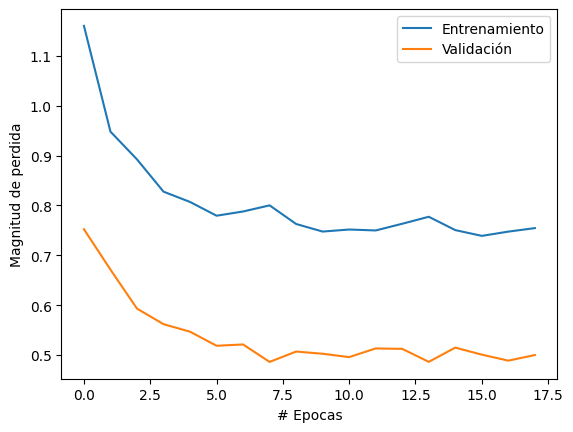

In [54]:
plt.xlabel('# Epocas')
plt.ylabel('Magnitud de perdida')
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.legend(['Entrenamiento','Validación'])